<a href="https://colab.research.google.com/github/Jaseelkt007/Generative_AI_basics/blob/main/Langvin_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Langevin sampling
* Langevin sampling is a way to generate samples from a probability distribution p(x), when you can't directly sample from it but you can compute how fast it goes up or down — its gradient.

Lets suppose we are blindfolded and walking on a hill landscape
  * The shape of hill = gradient
  * feel the which direction is uphill (gradient ascent)
  * but you also take random steps to explore more

This process helps you explore the shape of the hill, and over time, your position ends up being samples from the distribution p(x)

xt+1 = xt + epsilon/2 * d/dx(log(p(xt))) + sqrt(epsilon)*zt
  * zt = noise ~ N(0,1)
  * epsilon = step size
  * sqrt(epsilon)*zt = adds randomness


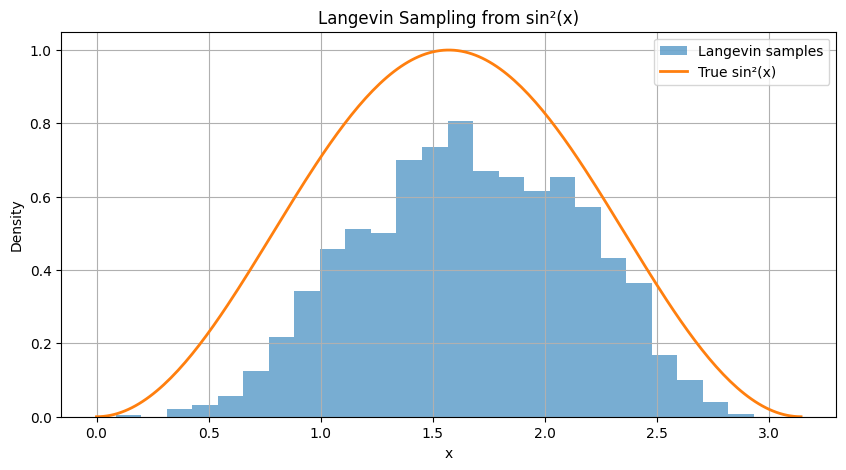

In [25]:
 # Example : sample from sine distribution

import numpy as np
import matplotlib.pyplot as plt


def p_unnormalized(x):
    return np.sin(x)**2 # p(x) ~ sin^2(x) , defined on [0,pi]
    # return np.cos(x)

# d/dx of log(sin^2) = 2 cos(x)/sin(x)
def log_p(x):
    return np.log(np.sin(x)**2 + 1e-8)
    # return np.log(np.cos(x) + 1e-8)

def grad_log_p(x):
    return  2* np.cos(x) / (np.sin(x) + 1e-8)
    # return -np.sin(x) / (np.cos(x) +1e-8)

# Sampling parameters
epsilon = 0.01
num_steps = 5000
burn_in = 1000 # ignore first few steps as warm ups

x = np.random.uniform(0.1, np.pi -0.1) # starting point (avoid 0, pi)
samples = []

# Langevin sampling loop
for i in range(num_steps):
    grad = grad_log_p(x)
    noise = np.sqrt(epsilon)* np.random.randn() # gaussian noise
    x = x + 0.5 *epsilon*grad + noise

    if x < 0:
        x = -x
    elif x > np.pi:
        x = 2 * np.pi - x

    if i > burn_in:
        samples.append(x)

xs = np.linspace(0, np.pi , 200)
true_dist = p_unnormalized(xs)
# true_dist /= np.sum(true_dist)

# plot
plt.figure(figsize=(10,5))
plt.hist(samples, bins=25, density=True, alpha = 0.6, label="Langevin samples")
plt.plot(xs, true_dist, label='True sin²(x)', linewidth=2)
plt.title("Langevin Sampling from sin²(x)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Consider P(x) = mixture of 2 guassian distribution(1D)
def p_unnormalized(x):
    gauss1 = np.exp(-0.5 * ((x + 2) / 0.5)**2) / (0.5 * np.sqrt(2 * np.pi))
    gauss2 = np.exp(-0.5 * ((x - 2) / 0.5)**2) / (0.5 * np.sqrt(2 * np.pi))
    return 0.5 * gauss1 + 0.5 * gauss2

def log_p(x):
    # Use log-sum-exp trick for numerical stability
    a = -0.5 * ((x + 2)/0.5)**2 - np.log(0.5 * 0.5 * np.sqrt(2 * np.pi))
    b = -0.5 * ((x - 2)/0.5)**2 - np.log(0.5 * 0.5 * np.sqrt(2 * np.pi))
    max_ab = np.maximum(a, b)
    return max_ab + np.log(np.exp(a - max_ab) + np.exp(b - max_ab))

def grad_log_p(x):
    # Compute gradients of each Gaussian component
    gauss1 = np.exp(-0.5 * ((x + 2) / 0.5)**2)
    gauss2 = np.exp(-0.5 * ((x - 2) / 0.5)**2)

    # Derivatives of each component
    d_gauss1 = -((x + 2) / (0.5**2)) * gauss1
    d_gauss2 = -((x - 2) / (0.5**2)) * gauss2

    numerator = 0.5 * d_gauss1 + 0.5 * d_gauss2
    denominator = 0.5 * gauss1 + 0.5 * gauss2 + 1e-8  # avoid divide by 0
    return numerator / denominator

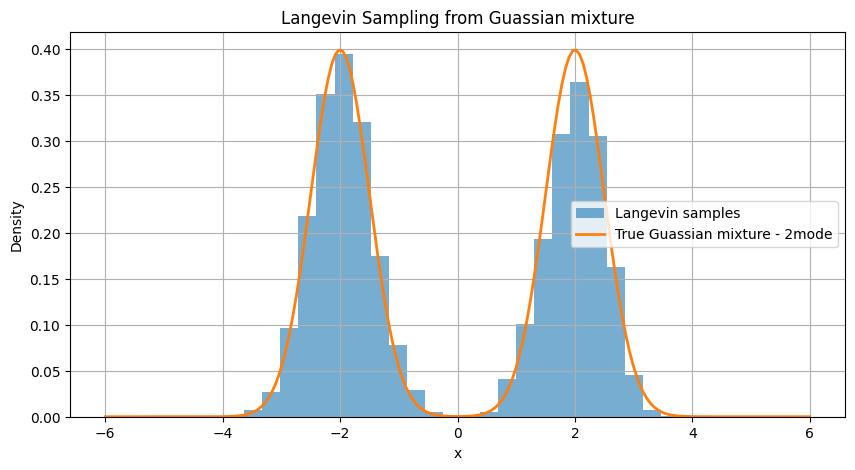

In [32]:
# Langevin sampling loop
for run in range(5):
    x = np.random.uniform(-3,3)
    for i in range(num_steps):
        grad = grad_log_p(x)
        noise = np.sqrt(epsilon)* np.random.randn() # gaussian noise
        x = x + 0.5 *epsilon*grad + noise

        # if x < 0:
        #     x = -x
        # elif x > np.pi:
        #     x = 2 * np.pi - x

        if i > burn_in:
            samples.append(x)

# xs = np.linspace(0, np.pi , 200)
xs = np.linspace(-6, 6 , 200)
true_dist = p_unnormalized(xs)
# true_dist /= np.sum(true_dist)

# plot
plt.figure(figsize=(10,5))
plt.hist(samples, bins=25, density=True, alpha = 0.6, label="Langevin samples")
plt.plot(xs, true_dist, label='True Guassian mixture - 2mode', linewidth=2)
plt.title("Langevin Sampling from Guassian mixture")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()